# Proyek Klasifikasi Gambar: Vegetables
- **Nama:** M. Gymnastiar
- **Email:** agimduduu@gmail.com
- **ID Dicoding:** agim_dudu

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip freeze > requirements.txt

In [2]:
# Library umum
import os
import shutil
import zipfile
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from random import sample
import matplotlib.pyplot as plt

In [3]:
# Library untuk pemrosesan data gambar
import cv2
import skimage
from PIL import Image
from skimage import io, transform, img_as_ubyte, exposure, util

In [4]:
# Library untuk TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, InputLayer, SeparableConv2D

In [5]:
# Library tambahan
from tqdm.notebook import tqdm as tq

In [6]:
# Library untuk evaluasi model
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.15.0


## Data Preparation

### Data Load

In [9]:
# Membuat folder dengan Nama: Dataset untuk memasukkan hasil ekstrak dataset yang di-download sebelumnya.
dataset_dir = 'Dataset'
os.mkdir(dataset_dir)

In [10]:
# mengekstrak file yg di download sebelumnya kedalam folder Dataset
target_file = 'Vegetables.zip'
extracting = zipfile.ZipFile(target_file, 'r')
extracting.extractall(dataset_dir)
extracting.close()

### Dataset Checking

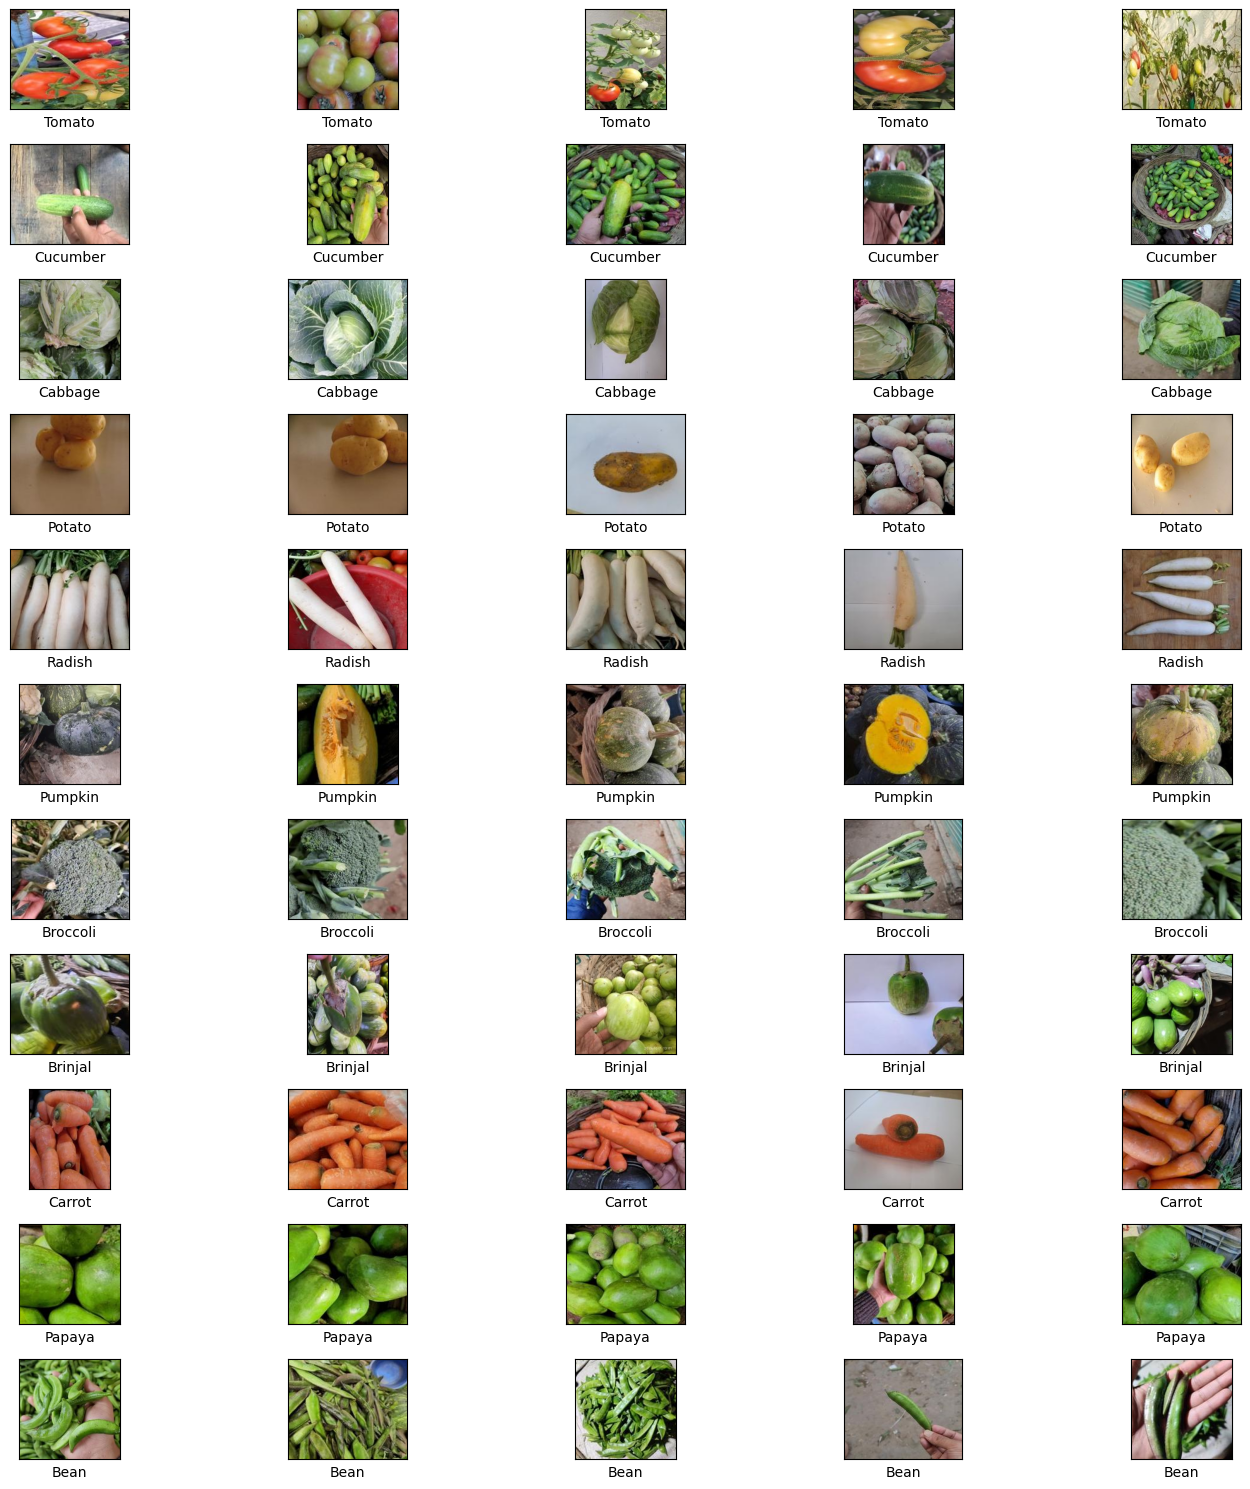

In [11]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = '/content/Dataset'

# Loop melalui setiap kelas dan simpan daftar nama file gambar dalam dictionary lung_image
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        lung_image[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(lung_image.keys()):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


In [12]:
# Cek Resolusi GAMBAR

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(path)

Tomato: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Cucumber: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Cabbage: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Potato: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Radish: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Pumpkin: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Broccoli: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Brinjal: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Carrot: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Papaya: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (200, 170)
- (190, 160)
---------------
Bean: 1000
- (160, 200)
- (160, 160)
- (224, 224)
- (

### Plot Distribusi All Data

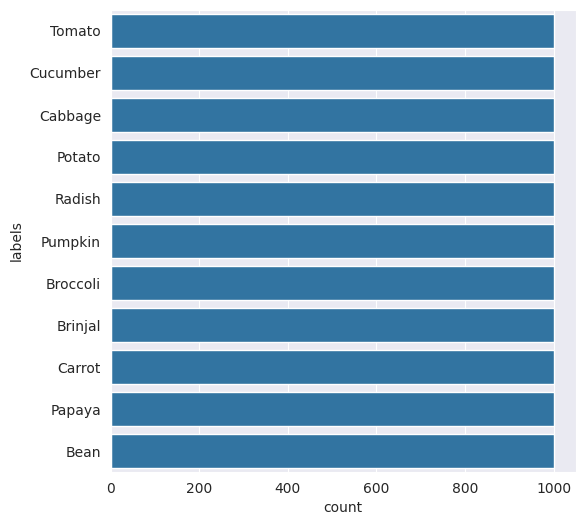

In [13]:
# Definisikan path sumber
lung_path = "/content/Dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

# Buat DataFrame dari data yang dikumpulkan
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

plt.show()


### Total Data

In [14]:
# Menampilkan total data dalam DataFrame distribution_train
total_data = distribution_train.shape[0]
print(f"Total data: {total_data}")

Total data: 11000


### Data Preprocessing

#### Split Dataset

In [15]:
# Daftar kelas atau label untuk dataset
classdir_list = ['Bean', 'Brinjal', 'Broccoli', 'Cabbage','Carrot', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

In [16]:
training_percentage = 0.8

In [17]:
training_dataset_dir = 'training'
testing_dataset_dir = 'testing'

os.mkdir(training_dataset_dir)
os.mkdir(testing_dataset_dir)

In [18]:
for dirname in classdir_list:
    classpath = os.path.join(dataset_dir, dirname)

    counter = 0
    training_length = training_percentage * len(os.listdir(classpath))

    training_classpath = os.path.join(training_dataset_dir, dirname)
    testing_classpath = os.path.join(testing_dataset_dir, dirname)

    os.mkdir(training_classpath)
    os.mkdir(testing_classpath)

    for filename in os.listdir(classpath):
        filepath = os.path.join(classpath, filename)

        if counter < training_length:
            shutil.move(filepath, training_classpath)
        else:
            shutil.move(filepath, testing_classpath)

        counter += 1


### Plot Distribusi Training Data

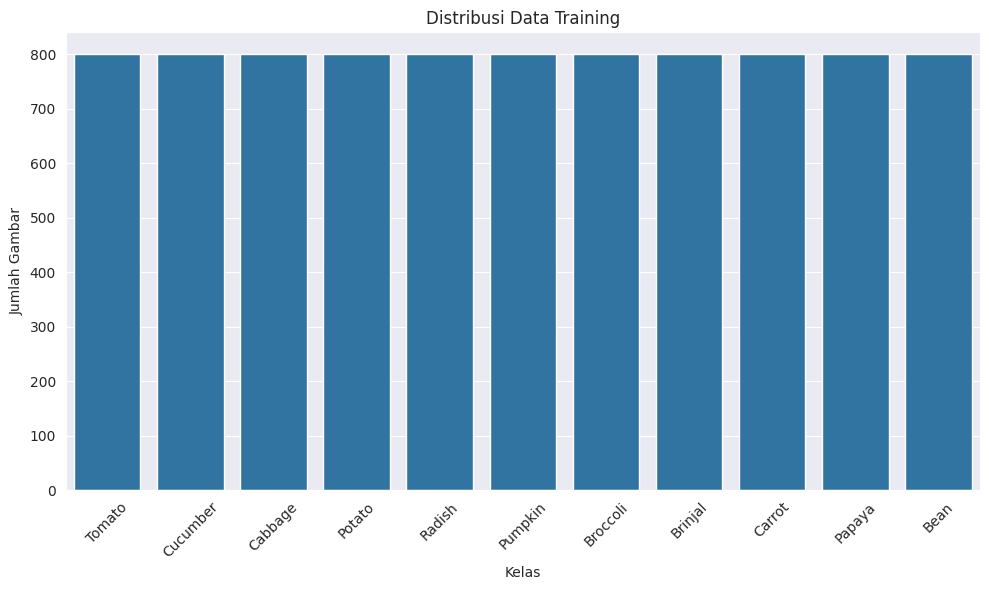

In [19]:
# Definisikan path sumber training
training_path = "/content/training"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
training_file_name = []
training_labels = []
training_full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(training_path):
    for name in files:
        training_full_path.append(os.path.join(path, name))
        training_labels.append(os.path.basename(path))
        training_file_name.append(name)

# Buat DataFrame dari data yang dikumpulkan
distribution_train = pd.DataFrame({"path": training_full_path, 'file_name': training_file_name, "labels": training_labels})

# Plot distribusi gambar di setiap kelas
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_train)

plt.title('Distribusi Data Training')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Plot Distribusi Testing Data

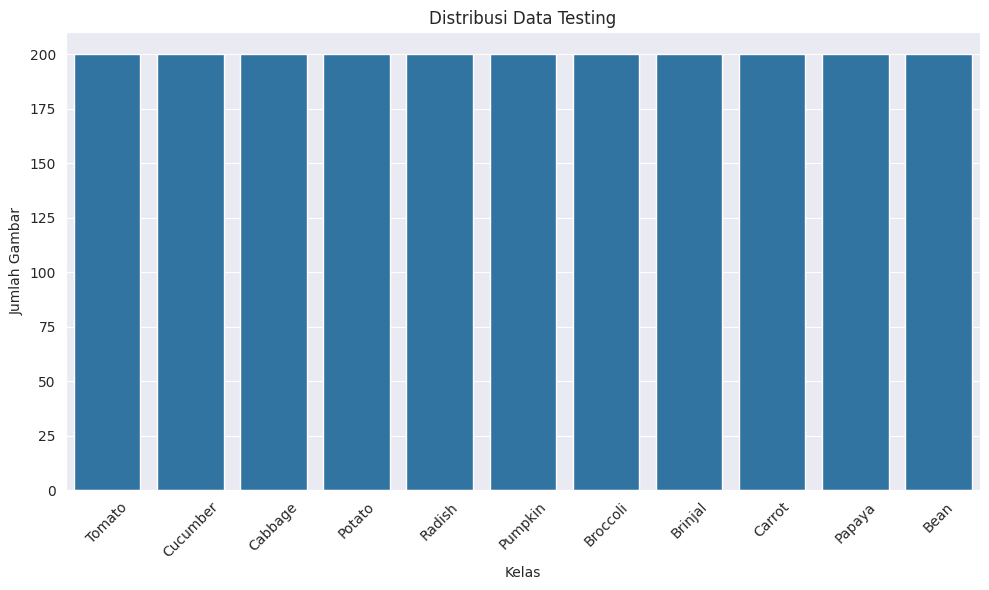

In [20]:
# Definisikan path sumber testing
testing_path = "/content/testing"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
testing_file_name = []
testing_labels = []
testing_full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(testing_path):
    for name in files:
        testing_full_path.append(os.path.join(path, name))
        testing_labels.append(os.path.basename(path))
        testing_file_name.append(name)

# Buat DataFrame dari data yang dikumpulkan
distribution_test = pd.DataFrame({"path": testing_full_path, 'file_name': testing_file_name, "labels": testing_labels})

# Plot distribusi gambar di setiap kelas
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_test)

plt.title('Distribusi Data Testing')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Image Data Generator

In [21]:
# Data Augmentasi
datagen = ImageDataGenerator(rescale=1./255,
                            validation_split = 0.2,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest',)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(training_path,
                                              batch_size=32,
                                              target_size=(150,150),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(training_path,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(testing_path,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 7040 images belonging to 11 classes.
Found 1760 images belonging to 11 classes.
Found 2200 images belonging to 11 classes.


## Modelling

In [22]:
model = Sequential([

    Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten layer
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

In [24]:
# Definisi Callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97:
            print("\nAkurasi pelatihan dan validasi telah mencapai >97%! Pelatihan dihentikan.")
            self.model.stop_training = True
callbacks = myCallback()

class EarlyStoppingAlert(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")


early_stopping = EarlyStopping(monitor='val_loss', patience=10 )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

early_stopping_alert = EarlyStoppingAlert()

callback_list = [early_stopping, reduce_lr, early_stopping_alert, callbacks]

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [26]:
hist = model.fit(
        train_generator,
        epochs = 100,
        validation_data = validation_generator,
        verbose = 2,
        callbacks = callback_list
    )

Epoch 1/100
220/220 - 63s - loss: 1.8276 - accuracy: 0.3266 - val_loss: 1.3353 - val_accuracy: 0.5068 - lr: 1.0000e-04 - 63s/epoch - 287ms/step
Epoch 2/100
220/220 - 54s - loss: 1.2360 - accuracy: 0.5635 - val_loss: 0.9745 - val_accuracy: 0.6653 - lr: 1.0000e-04 - 54s/epoch - 247ms/step
Epoch 3/100
220/220 - 55s - loss: 0.9365 - accuracy: 0.6747 - val_loss: 0.8590 - val_accuracy: 0.7028 - lr: 1.0000e-04 - 55s/epoch - 252ms/step
Epoch 4/100
220/220 - 54s - loss: 0.7862 - accuracy: 0.7354 - val_loss: 0.6162 - val_accuracy: 0.7955 - lr: 1.0000e-04 - 54s/epoch - 245ms/step
Epoch 5/100
220/220 - 53s - loss: 0.6800 - accuracy: 0.7707 - val_loss: 0.5519 - val_accuracy: 0.8114 - lr: 1.0000e-04 - 53s/epoch - 242ms/step
Epoch 6/100
220/220 - 54s - loss: 0.5956 - accuracy: 0.7955 - val_loss: 0.4972 - val_accuracy: 0.8267 - lr: 1.0000e-04 - 54s/epoch - 247ms/step
Epoch 7/100
220/220 - 54s - loss: 0.5518 - accuracy: 0.8058 - val_loss: 0.5137 - val_accuracy: 0.8295 - lr: 1.0000e-04 - 54s/epoch - 247

## Evaluasi dan Visualisasi

In [27]:
percen_loss=(hist.history['val_loss'][-1])
percen2_loss=(hist.history['loss'][-1])
# Cetak persentase loss
print("loss Validasi terakhir: {:.2f}".format(percen_loss))
print("loss Training terakhir: {:.2f}".format(percen2_loss))

loss Validasi terakhir: 0.10
loss Training terakhir: 0.11


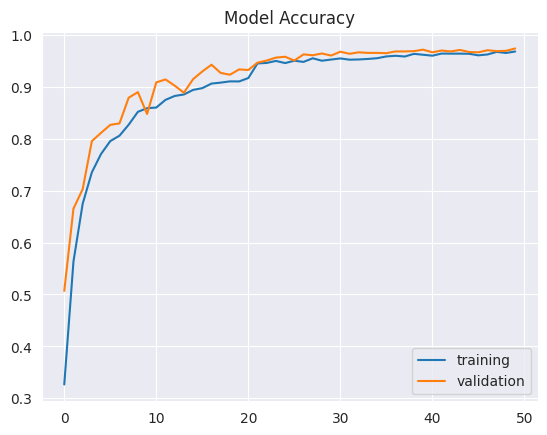

In [28]:
plt.plot(hist.history['accuracy'], label='training')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

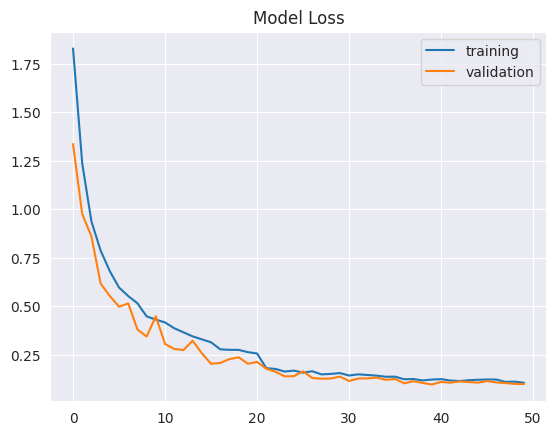

In [29]:
plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.legend()
plt.show()

In [30]:
train = model.evaluate(train_generator)
valid = model.evaluate(validation_generator)

print()
print(f'Training Accuracy : {train[1]*100:0.2f}')
print(f'Validation Accuracy : {valid[1]*100:0.2f}')

55/55 [==============================] - 11s 201ms/step - loss: 0.1036 - accuracy: 0.9722

Training Accuracy : 97.74
Validation Accuracy : 97.22




              precision    recall  f1-score   support

        Bean     0.9497    0.9437    0.9467       160
     Brinjal     0.9371    0.9313    0.9342       160
    Broccoli     0.9563    0.9563    0.9563       160
     Cabbage     0.9565    0.9625    0.9595       160
      Carrot     0.9877    1.0000    0.9938       160
    Cucumber     0.9565    0.9625    0.9595       160
      Papaya     0.9448    0.9625    0.9536       160
      Potato     1.0000    0.9938    0.9969       160
     Pumpkin     0.9810    0.9688    0.9748       160
      Radish     0.9876    0.9938    0.9907       160
      Tomato     0.9745    0.9563    0.9653       160

    accuracy                         0.9665      1760
   macro avg     0.9665    0.9665    0.9665      1760
weighted avg     0.9665    0.9665    0.9665      1760



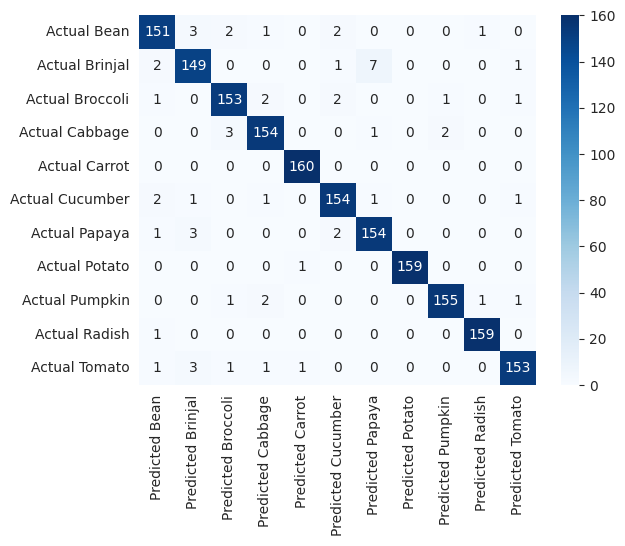

In [31]:
# Reset generator
validation_generator.reset()

# Melakukan prediksi
pred_validation = model.predict(validation_generator, verbose=0, batch_size=128)

# Mengubah probabilitas menjadi kelas biner
pred_validation_classes = pred_validation.argmax(axis=-1)

# Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(validation_generator.classes, pred_validation_classes, labels=list(range(len(classdir_list)))),
                  index=[f"Actual {label}" for label in classdir_list],
                  columns=[f"Predicted {label}" for label in classdir_list])
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')

# Classification Report
print("\n")
print(classification_report(y_true=validation_generator.classes, y_pred=pred_validation_classes, target_names=classdir_list, digits=4))




              precision    recall  f1-score   support

        Bean     0.9612    0.9900    0.9754       200
     Brinjal     0.9536    0.9250    0.9391       200
    Broccoli     0.8955    0.9850    0.9381       200
     Cabbage     0.9538    0.9300    0.9418       200
      Carrot     0.9950    1.0000    0.9975       200
    Cucumber     0.9848    0.9750    0.9799       200
      Papaya     0.9847    0.9650    0.9747       200
      Potato     0.9901    1.0000    0.9950       200
     Pumpkin     0.9742    0.9450    0.9594       200
      Radish     0.9950    0.9900    0.9925       200
      Tomato     0.9949    0.9700    0.9823       200

    accuracy                         0.9705      2200
   macro avg     0.9712    0.9705    0.9705      2200
weighted avg     0.9712    0.9705    0.9705      2200



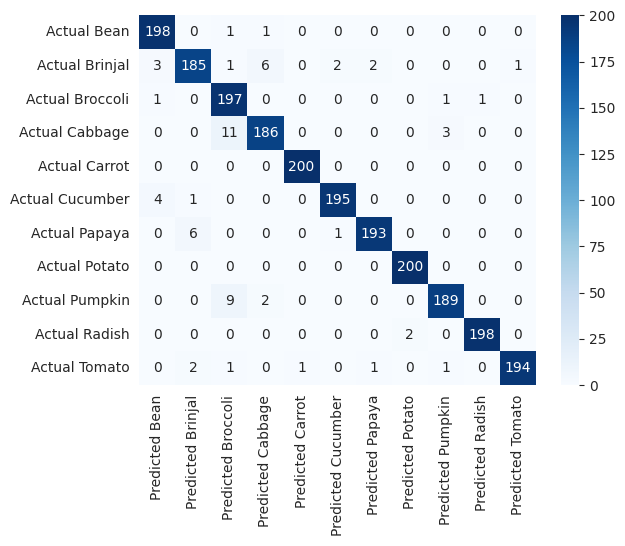

In [32]:
# Reset generator
test_generator.reset()

# Melakukan prediksi
pred_test = model.predict(test_generator, verbose=0, batch_size=32)

# Mengubah probabilitas menjadi kelas biner
pred_test_classes = pred_test.argmax(axis=-1)

# Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, pred_test_classes, labels=list(range(len(classdir_list)))),
                  index=[f"Actual {label}" for label in classdir_list],
                  columns=[f"Predicted {label}" for label in classdir_list])
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')

# Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes, y_pred=pred_test_classes, target_names=classdir_list, digits=4))


In [33]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

## Konversi Model

In [34]:
import tensorflow as tf
# Save Model to TfLite
saved_model_dir = "/content/saved_model"

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Membuat direktori 'tflite' jika belum ada
os.makedirs('tflite', exist_ok=True)

label_kelas = {
    0: 'Bean',
    1: 'Brinjal',
    2: 'Broccoli',
    3: 'Cabbage',
    4: 'Carrot',
    5: 'Cucumber',
    6: 'Papaya',
    7: 'Potato',
    8: 'Pumpkin',
    9: 'Radish',
    10: 'Tomato'
}

# Menyimpan label ke file teks tanpa tanda titik dua
with open('tflite/labels.txt', 'w') as f:
    for key, value in label_kelas.items():
        f.write(f"{key} {value}\n")

with tf.io.gfile.GFile('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [38]:
# Save Model to TFJS
!tensorflowjs_converter --input_format=tf_saved_model  /content/saved_model /content/tfjs_model

2024-07-15 12:51:09.033282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 12:51:09.154559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 12:51:09.154660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 12:51:12.135501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-15 12:51:18.115928: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


## Inference (Optional)

Saving resized_0068.jpg to resized_0068.jpg


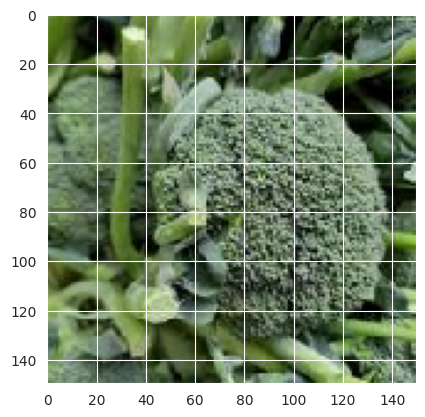

Kelas yang Diprediksi: Broccoli, Tingkat Keyakinan: 100.00%


In [36]:
from google.colab import files

# Unggah gambar
uploaded = files.upload()

# Ambil path gambar yang diunggah
image_path = list(uploaded.keys())[0]

# Load dan preprocess gambar
img = image.load_img(image_path, target_size=(150, 150))

# Display gambar
plt.imshow(img)
plt.show()

# Preprocess gambar untuk inferensi
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalisasi nilai piksel

# Path ke model TFLite
model_path = '/content/tflite/model.tflite'

# Load model TFLite dan alokasikan tensors
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Ambil input dan output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Siapkan data input
interpreter.set_tensor(input_details[0]['index'], x)

# Jalankan interpreter
interpreter.invoke()

# Ambil output
predictions = interpreter.get_tensor(output_details[0]['index'])

# Dapatkan kelas yang diprediksi dan keyakinan
predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class] * 100

# Peta kelas index ke label
label_kelas = { 0: 'Bean', 1: 'Brinjal', 2: 'Broccoli', 3: 'Cabbage', 4: 'Carrot', 5: 'Cucumber', 6: 'Papaya', 7: 'Potato', 8: 'Pumpkin', 9: 'Radish', 10: 'Tomato'}
label_prediksi = label_kelas[predicted_class]

# Cetak output
print(f"Kelas yang Diprediksi: {label_prediksi}, Tingkat Keyakinan: {confidence:.2f}%")


In [39]:
shutil.make_archive('/content/Submission_Dicoding', 'zip', '/content')

'/content/Submission_Dicoding.zip'